In [1]:
import pathlib
import random
import warnings

from numba import errors


warnings.filterwarnings("ignore", category=errors.NumbaDeprecationWarning)
warnings.filterwarnings("ignore", "TorchScript", category=UserWarning)
warnings.filterwarnings("ignore", "TypedStorage", category=UserWarning)

import torch
import hydra
import polars as pl
from torch.utils import data
import seaborn as sns
import umap
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

from recs_utils.neural_network.dataset import UserDataset, ItemDataset
from recs_utils.utils import load_pickle
from recs_utils.neural_network.model import NeuralNetRecommender

In [4]:
with hydra.initialize("configs", version_base="1.3"):
    training_config = hydra.compose("nn_rec", return_hydra_config=True)

In [5]:
exp_dir = pathlib.Path(training_config.hydra.run.dir)
del training_config

In [6]:
checkpoint_dir = exp_dir / "checkpoints"
config = exp_dir / ".hydra" / "config.yaml"

In [7]:
with hydra.initialize(str(config.parent), version_base="1.3"):
    exp_config = hydra.compose("config")

In [8]:
data_dir = pathlib.Path(exp_config.data_dir)

In [9]:
all_item_features = pl.read_parquet(data_dir / "features" / "items.parquet")

In [10]:
test_interactions = pl.read_parquet(data_dir / "interactions" / "test_inter.parquet")

In [11]:
feature_dir = pathlib.Path(exp_config.feature_dir)

In [12]:
user_features_nn = pl.read_parquet(feature_dir / "user_features.parquet")

In [13]:
item_features_nn = pl.read_parquet(feature_dir / "items.parquet")

In [14]:
user_encoder = load_pickle(exp_dir / "user_encoder.pickle")
item_encoder = load_pickle(exp_dir / "item_encoder.pickle")

In [15]:
user_dataset = UserDataset(user_features_nn.join(test_interactions.select(pl.col("user_id").unique()), on=["user_id"]), user_encoder)

In [16]:
item_dataset = ItemDataset(item_features_nn.join(test_interactions.select(pl.col("item_id").unique()), on=["item_id"]), item_encoder,
                           item_key_name="local_item_id", item_features_key_name="item_features")

In [17]:
checkpoint_path = exp_dir / "checkpoints" / "best-val-loss.ckpt"

In [18]:
model: NeuralNetRecommender = hydra.utils.instantiate(exp_config.model,
                                                        num_users=len(user_encoder.classes_),
                                                        num_items=len(item_encoder.classes_),
                                                          # minus user_id col
                                                          num_user_features=user_features_nn.shape[1] - 1,
                                                          # minus item_id col
                                                          num_item_features=item_features_nn.shape[1] - 1,
                                                          )

In [19]:
model.load_state_dict(torch.load(checkpoint_path, weights_only=True));
model.eval();

In [20]:
model = torch.jit.script(model)

In [21]:
user_info = user_dataset[random.sample(tuple(range(len(user_dataset))), k=5)]

In [22]:
with torch.no_grad():
    user_embedding = model.get_user_embedding(user_info["local_user_id"], user_info["user_features"])

In [23]:
def simple_collate_fn(batch):
    return batch[0]

In [24]:
item_dataloader = data.DataLoader(
    item_dataset,
    sampler=data.BatchSampler(data.SequentialSampler(item_dataset),
                                  batch_size=20_000, drop_last=False),
    collate_fn=simple_collate_fn
)

In [25]:
local_item_ids = []
item_embeddings = []

with torch.no_grad():
    for batch in item_dataloader:
        batch_item_embedding = model.get_item_embedding(batch["local_item_id"], batch["item_features"])
        local_item_ids.append(batch["local_item_id"])
        item_embeddings.append(batch_item_embedding)
        del batch
        del batch_item_embedding

In [26]:
local_item_ids = torch.cat(local_item_ids)
item_embeddings = torch.cat(item_embeddings, dim=0)

In [27]:
distances = torch.cdist(user_embedding, item_embeddings)

In [28]:
distance_info = pl.DataFrame({
    "distance": distances.view(-1).numpy(), 
    "user_id": user_encoder.inverse_transform(user_info["local_user_id"].numpy()).repeat(distances.shape[1])
}, schema={"distance": pl.Float32, "user_id": pl.Int32}
)

<Axes: xlabel='user_id', ylabel='distance'>

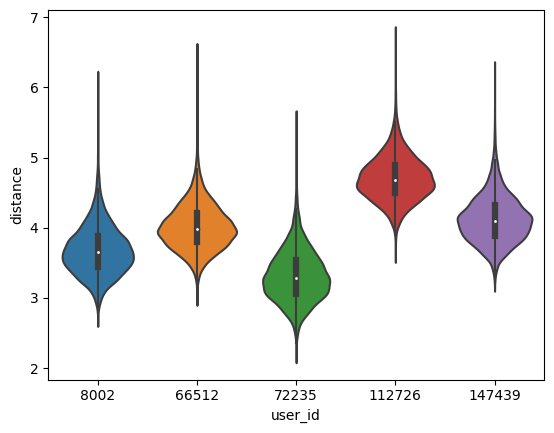

In [29]:
sns.violinplot(distance_info.to_pandas(use_pyarrow_extension_array=True), x="user_id", y="distance")

In [30]:
top_N = 10

In [31]:
nearthest_local_item_ids = torch.argsort(distances, dim=1)[1, :top_N]

In [32]:
item_ids = item_encoder.inverse_transform(nearthest_local_item_ids.numpy())

In [33]:
with pl.Config() as config:
    config.set_fmt_str_lengths(255)
    config.set_tbl_formatting("ASCII_FULL")
    config.set_tbl_hide_column_data_types(True)
    config.set_tbl_rows(-1)
    print(all_item_features.filter(pl.col("item_id").is_in(item_ids)))

shape: (10, 5)
+---------+-----------------------------+----------------------------+----------------------+------+
| item_id | title                       | genres                     | authors              | year |
+==================================================================================================+
| 10090   | волшебник                   | литература 20 века,русская | Владимир Набоков     | 1939 |
|         |                             | классика                   |                      |      |
|---------+-----------------------------+----------------------------+----------------------+------|
| 39321   | от болей в ногах и руках    | здоровье                   | Игорь Борщенко       | 2015 |
|---------+-----------------------------+----------------------------+----------------------+------|
| 11677   | по повестке и по призыву.   | военное дело /             | Юрий Мухин           | 2005 |
|         | некадровые солдаты великой  | спецслужбы,общая история   |      

In [34]:
low_dim_encoder = umap.UMAP(n_neighbors=10)

In [35]:
lower_dim_item_embeddings = low_dim_encoder.fit_transform(item_embeddings.numpy())

<Axes: >

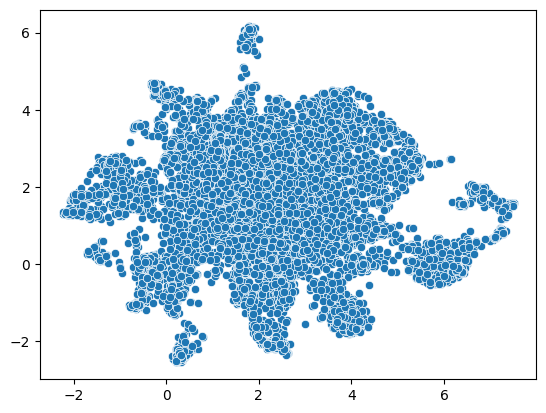

In [36]:
sns.scatterplot(x=lower_dim_item_embeddings[:, 0], y=lower_dim_item_embeddings[:, 1])